# Housing Price Prediction using Regression Model
---

# Content
- Problem Statement
- Data Dictionary
- Import Libraries and Data
- 1 Exploratory Data Analysis
- 2 Baseline Model
- 3 Feature Selection
- 4 Model after Feature Selection
- 5 Model Inference
- 6 Conclusion
- Appendix: Output for Kaggle Submission

---

# Problem Statement

This project aims to develop a regression model to predict property sale price, using a dataset of resdiential home features. Important features that help to uplift sale price will be identified. This will help homeowners or property agents in making optimal decisions in property transactions.

---

# Data Dictionary

Data dictionary of the dataset can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). The dataset contains 79 features and the sale price of residential homes in Ames, Iowa from 2006 to 2010.

---

# Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, RidgeCV,LassoCV,ElasticNetCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

In [3]:
#Import training dataset
train = pd.read_csv('raw datasets/train.csv')
print(train.shape)
train.head(2)

(2051, 81)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  

[2 rows x 81 columns]

In [4]:
#Import testing dataset
kaggle_test = pd.read_csv('raw datasets/test.csv')
print(kaggle_test.shape)
kaggle_test.head(2)

(878, 80)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   

[2 rows x 80 columns]

- kaggle_test dataset has no target variable ('SalePrice') inside

In [5]:
#Create feature maxtrix and target vector in training dataset
y = train['SalePrice']
X = train.drop(columns='SalePrice')

# 1 Exploratory Data Analysis

## 1.1 Duplicate Values

In [6]:
#Count duplicated observations
print(X.duplicated().sum())
print(kaggle_test.duplicated().sum())

0
0


- There are no duplicate values in both datasets.

## 1.2 Missing Values

### Missing Value Overview

In [7]:
#Count number of missing values in X
missing_df = pd.DataFrame(X.isnull().sum().reset_index(name = 'num_null'))

#Calculate percentage of missing values
missing_df['perc_null'] = missing_df['num_null']*100/len(X)

#Filter for columns with more than 5% missing values
missing_col = missing_df[missing_df['perc_null']>0].sort_values('perc_null',ascending=False)
missing_col[missing_col['perc_null']>5]

index  num_null  perc_null
73        Pool QC      2042  99.561190
75   Misc Feature      1986  96.830814
7           Alley      1911  93.174061
74          Fence      1651  80.497318
58   Fireplace Qu      1000  48.756704
4    Lot Frontage       330  16.089712
60  Garage Yr Blt       114   5.558264
65    Garage Cond       114   5.558264
64    Garage Qual       114   5.558264
61  Garage Finish       114   5.558264
59    Garage Type       113   5.509508

In [8]:
# Visualisations of all features with missing values
fig = px.imshow(X.isnull()[missing_col['index']])
fig.show()

General strategies for handling missing values would be:
1. Drop features with severe missing value problems, with more than **80% missing values**.
2. Investigate features with **more than 5% missing values** and identify any potential systematic patterns. At a glance, features with missing values are mainly the following types, and show some systematic patterns.
- Fireplace features
- Lot features
- Garage features
- Basement features
3. Impute missing values for features with **less than 5% missing values**.

### Severe Missing Values Problems
- Identify and remove features with more than 80% missing values

In [9]:
#Columns with more than 80% missing values
missing_80 = missing_col[missing_col['perc_null']> 80]['index']
missing_80

73         Pool QC
75    Misc Feature
7            Alley
74           Fence
Name: index, dtype: object

In [10]:
#Drop columns with more than 80% missing values in X
X.drop(columns = missing_80,inplace=True)

#Drop same columns in kaggle_test to make sure number of columns align
kaggle_test.drop(columns = missing_80,inplace=True)

### Investigate Missing Value Patterns
- Espeically for features with more than 5% of missing values:
    - Fireplace features
    - Lot features
    - Garage features
    - Basement features
- Investigate if there are systematic patterns in missing values (i.e. whether the missing values are missing completely at random). All related features of the above types, including those without missing values, would be identified and explored.

In [11]:
#Find all related features in the DataFrame to explore patterns in missing values

#Key = type of features, Value = Keyword to search for in columns
features_dict = {'lot_features':'Lot',
                 'fireplace_features':'Fireplace',
                'garage_features':'Garage',
                'basement_features':'Bsmt'}

#For-loop to preduce list of columns that contain the keywords
for features,keyword in features_dict.items():
    exec (f'{features} = train.columns[train.columns.str.contains(keyword)].tolist()')
    print(f'{features}')

lot_features
fireplace_features
garage_features
basement_features


In [12]:
#Function to return missing value overview after inputting the feature name
def missing_value_overview(feature_name):
    
    #Summary of missing value counts
    print(X[feature_name].isnull().sum())
    
    #Visualisation of missing values
    fig = px.imshow(X[feature_name].isnull())
    fig.show()
    
    #Print unique values for each string variable
    for feature in feature_name:
        if X[feature].dtype == object:
            print(f'Feature {feature} has unique values {X[feature].unique()}')

**Lot Features**

In [13]:
# Step 1: Overview
missing_value_overview(lot_features)

Lot Frontage    330
Lot Area          0
Lot Shape         0
Lot Config        0
dtype: int64


Feature Lot Shape has unique values ['IR1' 'Reg' 'IR2' 'IR3']
Feature Lot Config has unique values ['CulDSac' 'Inside' 'Corner' 'FR2' 'FR3']


- Only lot frontage has missing values while the other lot features do not.

In [14]:
# Step 2: Check summary statistics for rows with missing values in 'Lot Frontage'
X.loc[X['Lot Frontage'].isnull(),lot_features].describe(include='all')

Lot Frontage       Lot Area Lot Shape Lot Config
count            0.0     330.000000       330        330
unique           NaN            NaN         4          5
top              NaN            NaN       IR1     Inside
freq             NaN            NaN       223        190
mean             NaN   12373.660606       NaN        NaN
std              NaN   12102.692705       NaN        NaN
min              NaN    1533.000000       NaN        NaN
25%              NaN    8127.000000       NaN        NaN
50%              NaN   10601.500000       NaN        NaN
75%              NaN   12958.250000       NaN        NaN
max              NaN  159000.000000       NaN        NaN

- Note that top counts of 'Lot Config' is 'Inside Lot', for rows with missing values in 'Lot Frontage'

In [15]:
# Step 3: Examine 'Lot Configuration' for rows with missing values in 'Lot Frontage'
X.loc[X['Lot Frontage'].isnull(),'Lot Config'].value_counts()

Inside     190
Corner      67
CulDSac     61
FR2         11
FR3          1
Name: Lot Config, dtype: int64

- This confirms that most missing values mean the property has an inside lot and the lot frontage should be 0.

In [16]:
# Step 4: Fill the missing values in 'Lot Frontage' with 0, for houses with inside lot
X.loc[X['Lot Config'] == 'Inside', 'Lot Frontage'] = X.loc[X['Lot Config'] == 'Inside', 'Lot Frontage'].fillna(0)

# Remaining missing values
X[lot_features].isnull().sum()

Lot Frontage    140
Lot Area          0
Lot Shape         0
Lot Config        0
dtype: int64

**Fireplace Features**

In [17]:
# Step 1: Overview
missing_value_overview(fireplace_features)

Fireplaces         0
Fireplace Qu    1000
dtype: int64


Feature Fireplace Qu has unique values [nan 'TA' 'Gd' 'Po' 'Ex' 'Fa']


In [18]:
# Step 2: Check summary statistics for rows with missing values in 'Fireplace Qu'
X.loc[X['Fireplace Qu'].isnull(), fireplace_features].describe(include='all')

Fireplaces Fireplace Qu
count       1000.0            0
unique         NaN            0
top            NaN          NaN
freq           NaN          NaN
mean           0.0          NaN
std            0.0          NaN
min            0.0          NaN
25%            0.0          NaN
50%            0.0          NaN
75%            0.0          NaN
max            0.0          NaN

- Notice that for rows with missing values in Fireplace Qu, number of fireplace is all 0.
- Missing value in Fireplace Qu has a meaning: absence of fireplace.

**Garage Features & Basement Features**

- Similar steps were taken to explore missing values in garage and basement features
- Similarly, missing values meant absence of garage or basement

### Summary on Missing Values

1. Drop features with more than 80% missing values.
2. Features with more than 5% missing values were assoicated with the following meanings
- No frontage: Lot Frontage
- No fireplace: Fireplace Qu
- No garage: Garage Type, Garage Finish, Garage Qual, Garage Cond
- No basement: Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type 2

In [19]:
# List of features with missing values, and the missing values represent absence of some facilities
missing_list = ['Fireplace Qu',
                'Garage Type','Garage Finish','Garage Qual','Garage Cond',
               'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2']

# Fill missing values in these columns with the string 'missing', to differentiate them from other missing values
X[missing_list] = X[missing_list].replace(np.nan,'missing')

- These missing values will be replaced with numbers in the following section when transforming data types.

## 1.3 Data Types

### Ordinal features

Based on [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), three groups of **ordinal features** were identified:
- Quality features - ranking goes according to 'quality_map'
- Basement quality features - ranking goes according to 'bsmt_quality_map'
- Other ordinal features - each feature has unique ranking

Note: The missing values identified previously will be mapped as 0 on ordinal scales

In [20]:
#Quality features - ranking goes according to quality_map
quality_features = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC',
                  'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond']
quality_map = {'missing':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}

#Basement quality features - ranking goes according to bsmt_quality_map
bsmt_quality = ['BsmtFin Type 1', 'BsmtFin Type 2']
bsmt_quality_map = {'missing':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}

#Other ordinal features - each has unique ranking
other_ordinal_features = ['Lot Shape','Land Slope','Bsmt Exposure','Functional','Garage Finish',
                          'Utilities','Paved Drive']

other_ordinal_map = {'Lot Shape':{'IR3':0,'IR2':1,'IR1':2,'Reg':3},
                     'Land Slope':{'Sev':0,'Mod':1,'Gtl':2},
                     'Bsmt Exposure':{'missing':0,'No':1,'Mn':2,'Av':3,'Gd':4},
                     'Functional':{'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
                     'Garage Finish':{'missing':0,'Unf':0,'RFn':1,'Fin':2},
                     'Utilities':{'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3},
                     'Paved Drive':{'N':0,'P':1,'Y':2}}

#All ordinal features
ordinal_features = quality_features + bsmt_quality + other_ordinal_features

In [21]:
#Function to apply ordinal mapping on dataset
def ordinal_mapper(df):
    #1. Apply quality_map on quality_features
    df[quality_features] = df[quality_features].replace(quality_map)
    
    #2. Apply bsmt_quality_map on bsmt_quality
    df[bsmt_quality] = df[bsmt_quality].replace(bsmt_quality_map)
    
    #3. For loop to map each of the unique rankings in other_ordinal_features
    for feature in other_ordinal_features:
        df[feature] = df[feature].map(other_ordinal_map[feature])

In [22]:
# Map the ordinal features in X and kaggle_test
ordinal_mapper(X)
ordinal_mapper(kaggle_test)

In [23]:
# Confirm that all missing values in ordinal features are replaced
X[ordinal_features].isnull().sum()

Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Heating QC        0
Kitchen Qual      0
Fireplace Qu      0
Garage Qual       0
Garage Cond       0
BsmtFin Type 1    0
BsmtFin Type 2    0
Lot Shape         0
Land Slope        0
Bsmt Exposure     0
Functional        0
Garage Finish     0
Utilities         0
Paved Drive       0
dtype: int64

### Categorical features

- All the string columns that were not transformed to ordinal will be classified as categorical features
- An additional feature 'MS SubClass' was converted from numeric to categorical features. MS SubClass represents the type of houses, which are categorical in nature.

In [24]:
#Find all string features
string_features = X.select_dtypes(include='object').columns

In [25]:
#Find the categorical features
#String features minus those converted to ordinal features
categorical_features = string_features[~string_features.isin(ordinal_features)].tolist()
categorical_features

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Electrical',
 'Garage Type',
 'Sale Type']

In [26]:
# Add 'MS Subclass' (originally stored as integer) to categorical feature
categorical_features.append('MS SubClass')
X['MS SubClass'] = X['MS SubClass'].astype('str')
X['MS SubClass'].unique()

array(['60', '20', '50', '180', '160', '70', '120', '190', '85', '30',
       '90', '80', '75', '45', '40', '150'], dtype=object)

### Identifier

- Identifiers are features that have unique values in every row
- They will be dropped from numeric features

In [27]:
#Find identifier in the datasets
identifier = X.nunique()[X.nunique() == len(X)].index.tolist()
identifier

['Id', 'PID']

In [28]:
# Remove identifier from X
X = X.drop(columns=identifier)
print(X.shape)

(2051, 74)


### Numeric features

In [29]:
#Find numeric features
#Drop the identifiers from numeric features
numeric_features = X.select_dtypes(include=['int','float']).columns.tolist()
print(len(numeric_features))

53


### Summary on Data Types

The entire X datasets are now categorised into the following three types for ease of subsequent analysis.
- identifier
- numeric features
- categorical features

All the ordinal features identified previously will now be included in numeric features.

## 1.4 Feature Engineering

Five additional features are created from exisitng features
- **'Age'**: Age of the property at time of being sold, since built
- **'Age Since Remod'**: Age of the property at time of being sold, since last remodification
-  **'Total Bathroom'**: Total number of bathrooms
- **'Total Area'**: Total living area in the house
- **'Total Porch'**: Total porch area

In [30]:
# Function to create the five additional features
def create_new_features(df):
    df['Age'] = df['Yr Sold'] - df['Year Built']
    df['Age Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Total Bathroom'] = df['Bsmt Full Bath'] + 0.5*df['Bsmt Half Bath'] + df['Full Bath'] + 0.5*df['Half Bath']
    df['Total Area'] = df['Gr Liv Area'] + df['Total Bsmt SF']

In [31]:
# Create new features in X and kaggle_test
create_new_features(X)
create_new_features(kaggle_test)
print(X.shape)
print(kaggle_test.shape)

(2051, 78)
(878, 80)


In [32]:
# Update the numeric features list
numeric_features = X.select_dtypes(include=['int','float']).columns.tolist()
len(numeric_features)

57

**Visualising new features**
- Visually examine if the new features have any relationship with target response 'SalePrice'

In [33]:
# List of new features
new_features = ['Age','Age Since Remod','Total Bathroom','Total Area']
Xy = X.join(y)

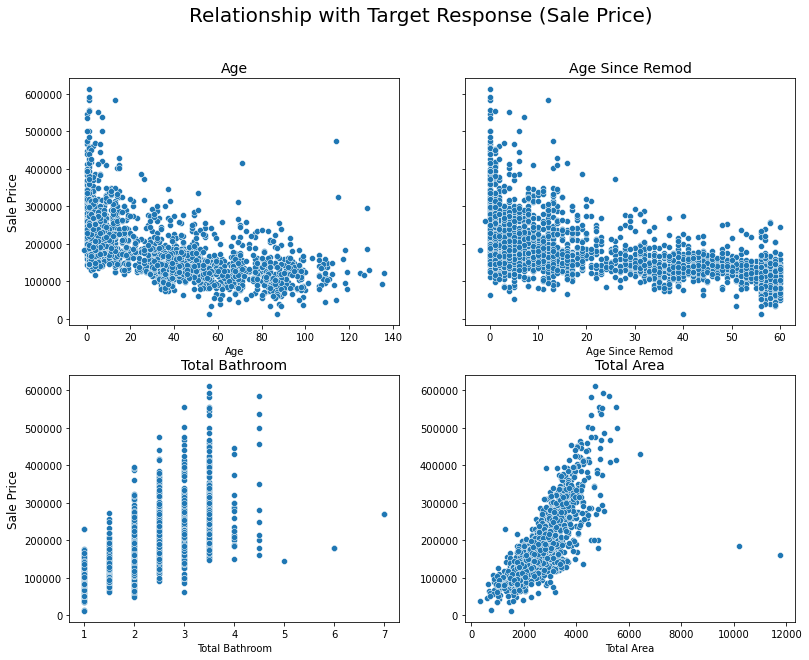

In [34]:
fig, ax = plt.subplots(nrows=2, 
                       ncols=2, 
                       sharey=True,
                       figsize = (13,10))
ax = ax.ravel()

for i, feature in enumerate(new_features):
    sns.scatterplot(data=Xy, x=feature, y='SalePrice', ax=ax[i], palette="Blues");
    ax[i].set_title(f'{feature}', fontsize=14)
    ax[i].set_ylabel('Sale Price', fontsize=12)

plt.tick_params(left=True, labelleft=True)
plt.suptitle('Relationship with Target Response (Sale Price)', fontsize=20);

- The new features appear to show somewhat linear relationship with the target response 'SalePrice'.

## 1.5 Distribution
Visually examine if:
- numeric features are normally distributed.
- categorical features are imbalanced.

### Distribution of Numeric Features

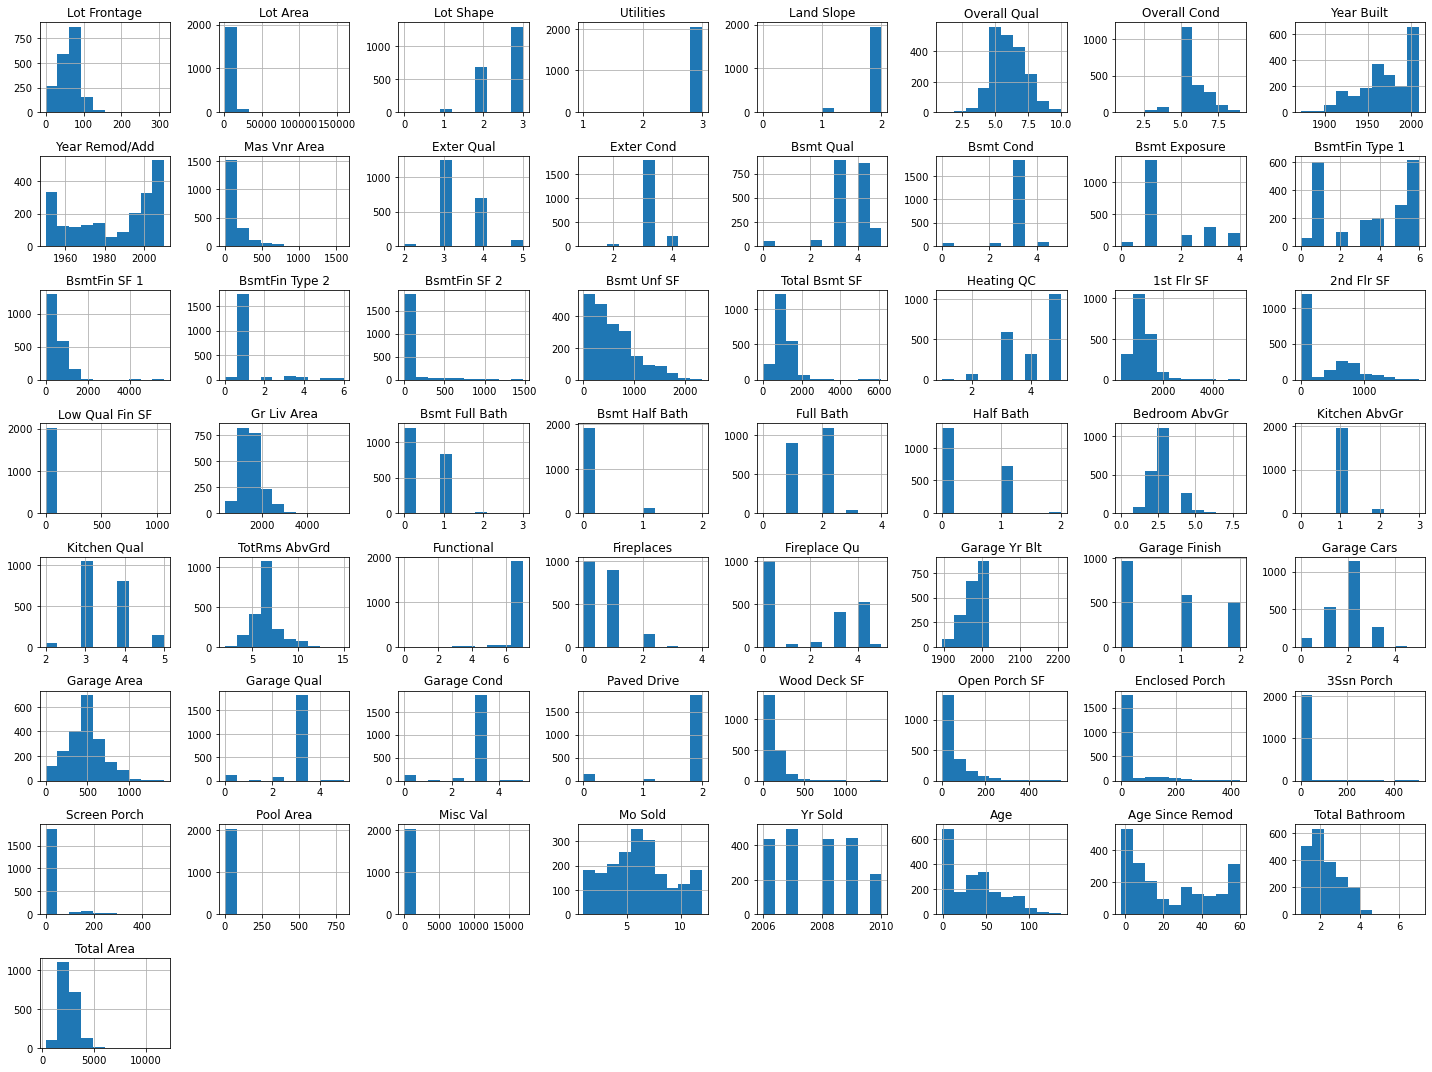

In [35]:
X.hist(figsize=(20,15))
plt.tight_layout();

- There are a mixture of normally and non-normally distributed features.
- Some features appear to be normally distributed (e.g. 'Garage Area')
- Some features show positive (e.g. 'Total Bathroom'), while some show negative skew (e.g.'Year Built')
- There are also some features that have values clustering in a small range (e.g. 'Misc Val') and are apparently not normally distributed

### Distribution of Cateogrical Features

In [36]:
# For ease of viewing, split categorical features into two groups based on number of categories in each feature
sparse_cat = [feature for feature in categorical_features if X[feature].nunique() < 10]
dense_cat = [feature for feature in categorical_features if X[feature].nunique() >= 10]

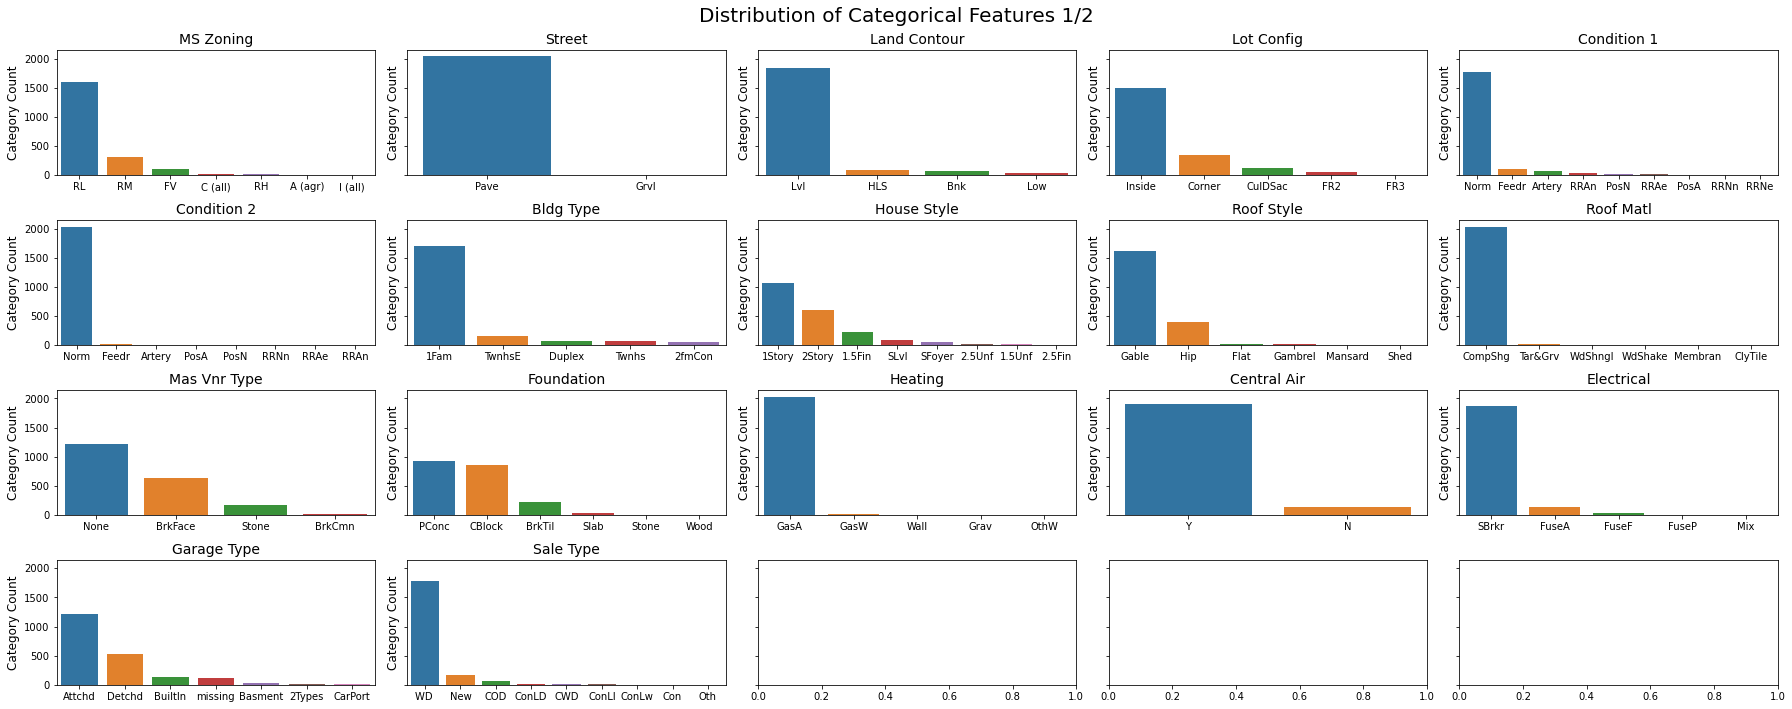

In [37]:
# Distribution for sparse_cat
fig, ax = plt.subplots(nrows=int(np.ceil(len(sparse_cat)/5)), 
                       ncols=5, 
                       sharey=True,
                       figsize = (25,10))
ax = ax.ravel()

for i, feature in enumerate(sparse_cat):
    sns.barplot(data=X, x=X[feature].value_counts().index, y=X[feature].value_counts(), ax=ax[i]);
    ax[i].set_title(f'{feature}', fontsize=14)
    ax[i].set_ylabel('Category Count', fontsize=12)

plt.tick_params(left=True)
plt.suptitle('Distribution of Categorical Features 1/2', fontsize=20)
plt.tight_layout();

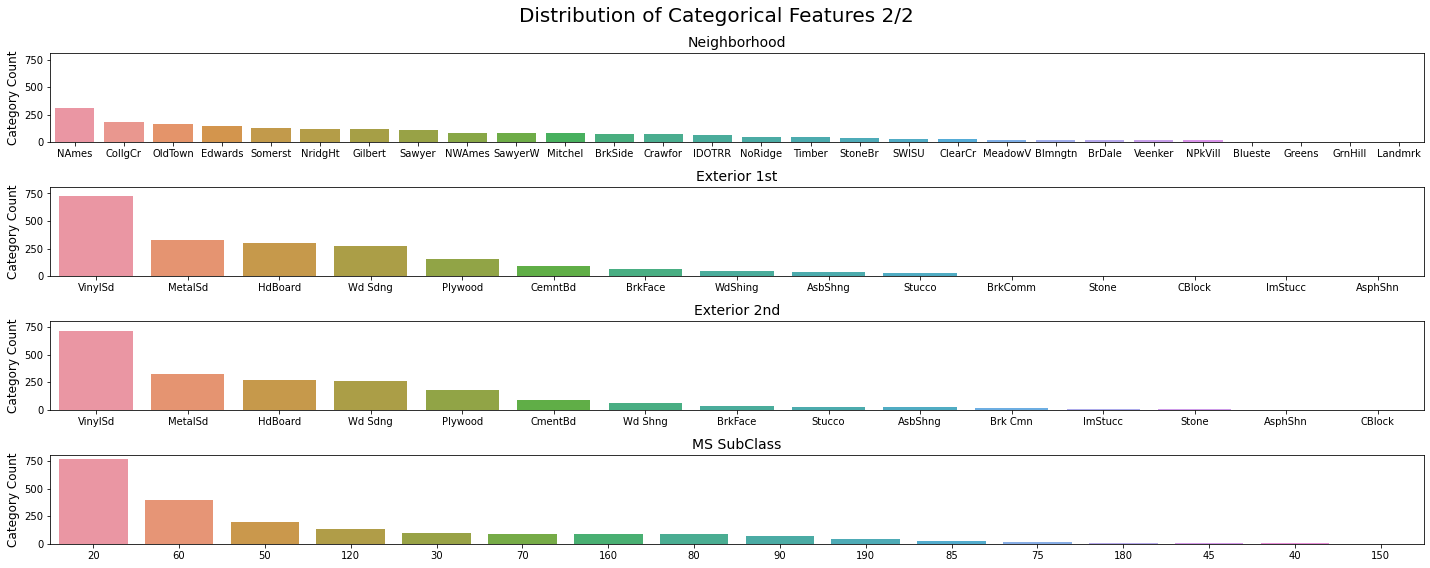

In [38]:
# Distribution for dense_cat
fig, ax = plt.subplots(nrows=len(dense_cat), 
                       ncols=1, 
                       sharey=True,
                       figsize = (20,8))
ax = ax.ravel()

for i, feature in enumerate(dense_cat):
    sns.barplot(data=X, x=X[feature].value_counts().index, y=X[feature].value_counts(), ax=ax[i]);
    ax[i].set_title(f'{feature}', fontsize=14)
    ax[i].set_ylabel('Category Count', fontsize=12)

plt.tick_params(left=True, labelleft=True)
plt.suptitle('Distribution of Categorical Features 2/2', fontsize=20)
plt.tight_layout();

- There are a mix of balanced and imbalanced categorical features.
- Balanced categorical feature has data points spread out evenly across different groups (e.g. 'Neighborhood')
- There are quite a number of categorical features with data points concentrated in one or a few group(s) (e.g. 'Street'). These features may have limited utilities in predictive models.

## 1.6 Outliers
- Identify outliers using boxplots

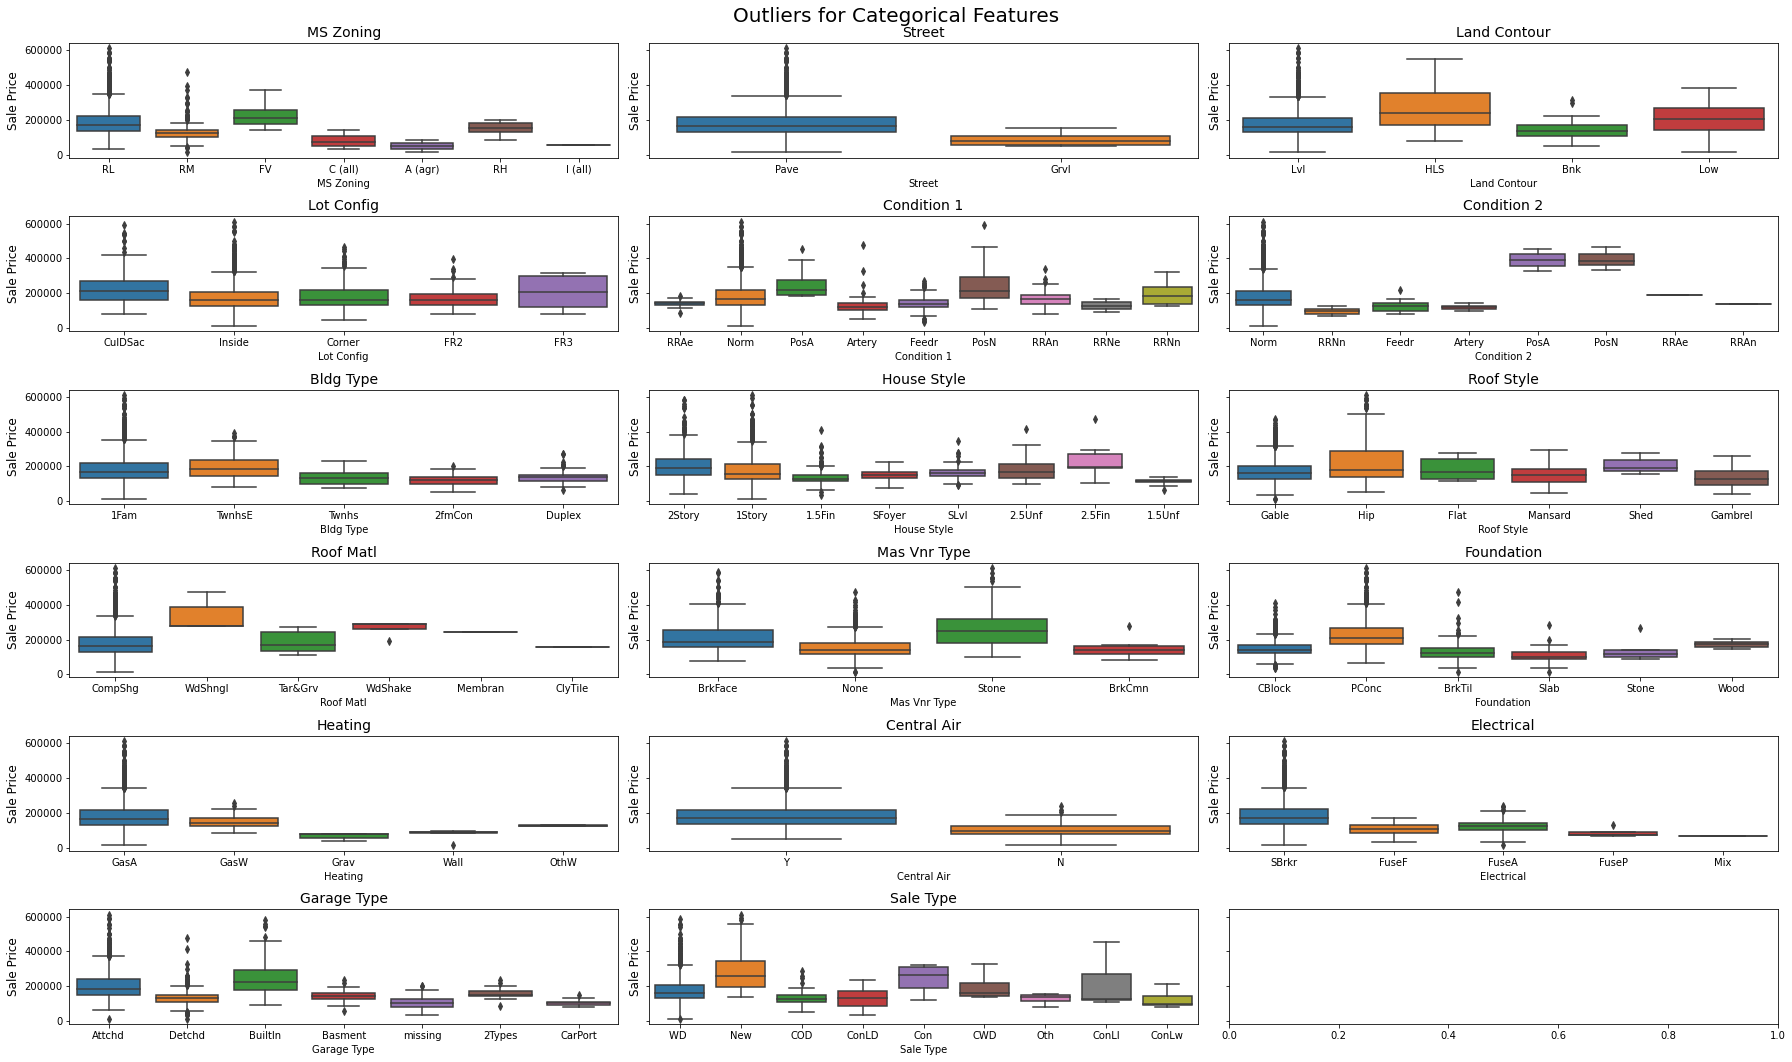

In [39]:
# Find outliers in categorical features (sparse_cat only as an example)
fig, ax = plt.subplots(nrows=int(np.ceil(len(sparse_cat)/3)),
                       ncols=3, 
                       sharey=True,
                       figsize = (25,15))
ax = ax.ravel()

for i, feature in enumerate(sparse_cat):
    sns.boxplot(data=Xy, x=feature, y='SalePrice', ax=ax[i]);
    ax[i].set_title(f'{feature}', fontsize=14)
    ax[i].set_ylabel('Sale Price', fontsize=12)

plt.tick_params(left=True)
plt.suptitle('Outliers for Categorical Features', fontsize=20)
plt.tight_layout();

- Similar analysis were run on other features
- Results showed outliers are present across multiple features, such as 'MS Zoning' (higher than average property price in RL zone)
- Outliers will be removed later in data processing to reduce the variability in the datasets

## 1.7 Correlation
- Correlation between features to check multicollinearity
- Correlation between features and target response ('Sale Price') to preliminarily check for potential predictors

### Correlation Between Features (Multicollinearity)

In [40]:
corr_features = X.corr()

#Filter for highly correlated features (r > 0.5), exclude correlation coefficients with self (r = 1)
high_corr = corr_features[(corr_features > 0.5) & (corr_features !=1)]

#Remove features with r < 0.5 from plot
high_corr_filtered = high_corr.dropna(axis=0,how='all').dropna(axis=1,how='all')

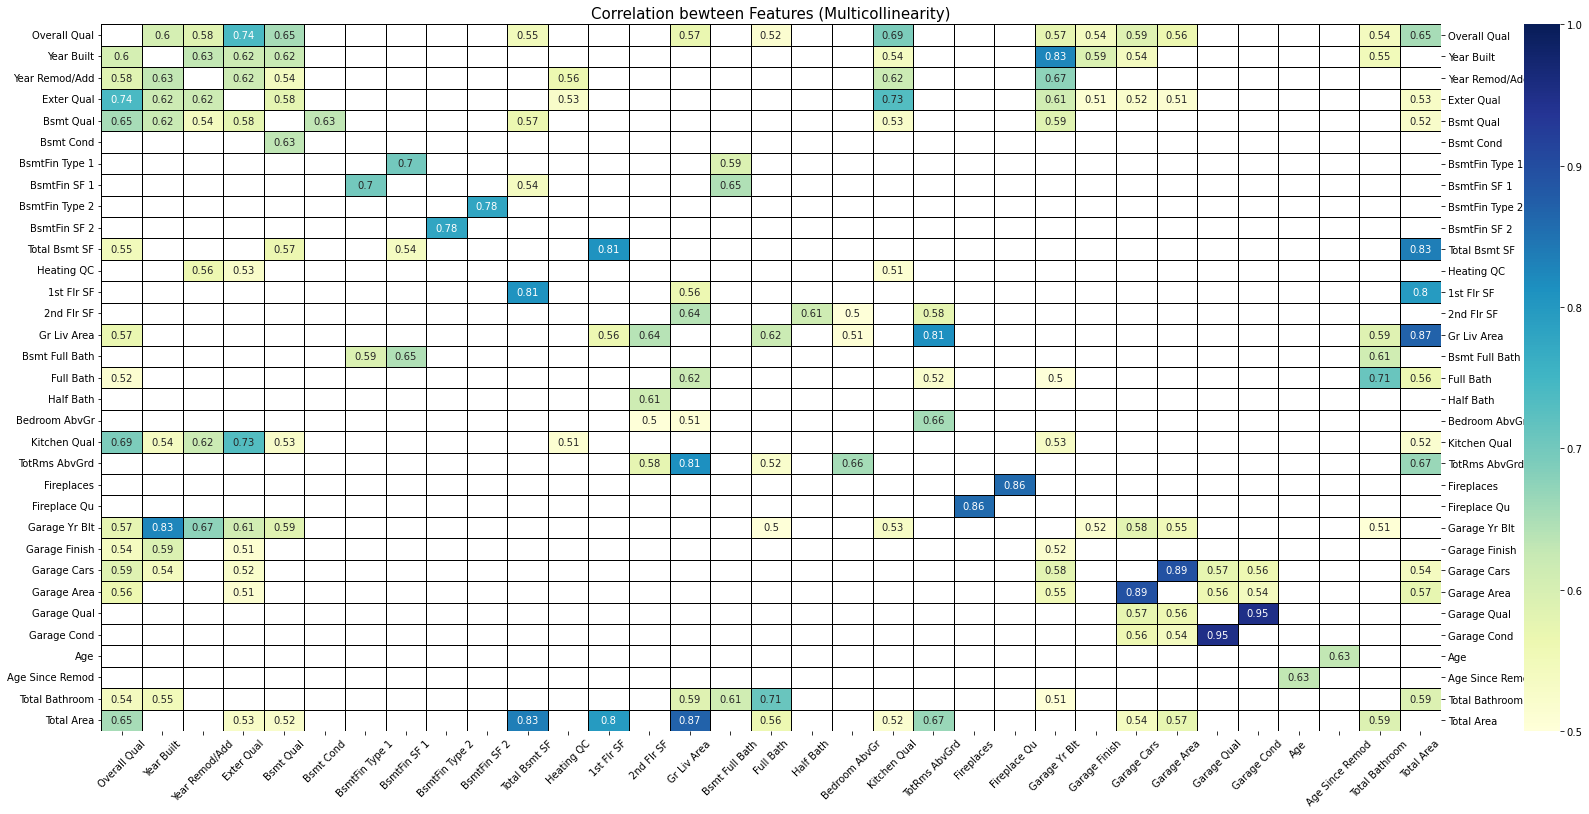

In [41]:
#Heatmap that only shows highly correlated features
plt.figure(figsize=(30,13))
sns.heatmap(high_corr_filtered,annot=True,cmap='YlGnBu',vmin=0.5,vmax=1,linewidths=1, linecolor='black') #Scale is set at min = 0.5 since the filtered coefficients is all > 0.5
plt.tick_params(right=True, labelright=True) #Label y-axis on both left and right sides
plt.title('Correlation bewteen Features (Multicollinearity)',{'fontsize':15});
plt.xticks(rotation=45)
plt.yticks(rotation=0);

- A few pairs of features are highly correlated (correlation coefficients > 0.8), such as 'Garage Qual' and 'Garage Cond'
- Multicollinearity exists in this dataset and will affect model accuracy
- Feature selections removing correlated features are needed to improve model performance

### Correlation Between Features And Sale Price

In [42]:
# Correlation coefficients bewteen features and sale price
corr_xy = Xy.corr()['SalePrice']

# Filter for significant features with > 0.6 or <-0.6 correlation coefficients
sig_features = corr_xy[(abs(corr_xy)>0.6) & (corr_xy != 1)]
sig_features

Overall Qual      0.800207
Exter Qual        0.712146
Bsmt Qual         0.612188
Total Bsmt SF     0.628925
1st Flr SF        0.618486
Gr Liv Area       0.697038
Kitchen Qual      0.692336
Garage Cars       0.648220
Garage Area       0.650270
Total Bathroom    0.629500
Total Area        0.779239
Name: SalePrice, dtype: float64

- A number of features have strong correlation coefficients with sale price. 
- They could be important features in building a predictive model.

## 1.8 Insighst from Exploratory Data Analysis

- A few features have been found to have strong correlation with sale price, suggesting that they are potentially useful predictors for property sale price.
- Use of regression models is apporpriate because of its explainability. It will be able to tell which features are important for property price.
<br>

**Considerations for Further Data Processing**
- With multicollinearity between features, regularization models that shrink the sizes of coefficients (lasso, ridge or elastic net) are required.
- There are outliers that need to be addressed. [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) will be used to detect and remove outliers.
- Making sure features are all on the same scale wil be important to avoid features on larger scale from dominating the predictive model. With a mixture of numeric and categorical features, Standard Scaler is not able to scale categorical features to the same scale as the numeric features. Therefore, [Min Max Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) may be more appropriate as it scales features to bewtween 0 and 1, which will be aligned with the values of one-hot-encoded categorical features.


# 2 Baseline Model
- Baseline model will be run without feature selections and with default parameters
- Performance of baseline model will serve as benchmark, to check whether model performance improves after feature selections

## 2.1 Train-Test Split

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

X_train.to_csv('cleaned datasets/X_train.csv',index=False)
y_train.to_csv('cleaned datasets/y_train.csv',index=False)

(1538, 78)
(513, 78)
(1538,)


## 2.2 Transformation Pipeline

Transformation for **numeric features**:
- Missing value imputation using mean
- Min max scaling

Transformation for **categorical features**:
- Missing value imputation using mode
- One hot encoding

In [44]:
#Transformation for numeric features
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

#Transformation for categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('dummify', OneHotEncoder(drop = 'first', handle_unknown='ignore'))])

#Combine the two transformation pipelines into one
preprocessor_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categorical_features)])

In [45]:
#Transform X_train and X_test
X_train = preprocessor_pipeline.fit_transform(X_train)
X_test = preprocessor_pipeline.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(1538, 205)
(513, 205)


/Users/yangyangxie/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning:

Found unknown categories in columns [4, 10] during transform. These unknown categories will be encoded as all zeros



## 2.2 Remove Outliers

In [46]:
lof = LocalOutlierFactor()

# Create a filter for non-outlier
non_outlier = lof.fit_predict(X_train) != -1

# Remove outliers
X_train, y_train = X_train[non_outlier,:], y_train[non_outlier]
print(X_train.shape)
print(y_train.shape)

(1533, 205)
(1533,)


## 2.3 Model Fitting

In [47]:
# Function to train model and return scores
def model_train (estimator,X_train = X_train,y_train = y_train, X_test = X_test,y_test = y_test):
    
    #Train score
    model = estimator.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    
    #Test score and test RMSE
    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    test_RMSE = mean_squared_error(y_test,y_pred,squared=False)
    
    #Output all scores
    print(f'estimator = {estimator}, train score = {round(train_score,3)}, test score = {round(test_score,3)}, test RMSE = {round(test_RMSE,0)}')
    return model

In [48]:
# List of estimators
estimators = [LinearRegression(),
             RidgeCV(),
             LassoCV(max_iter=20000),
             ElasticNetCV()]

# For loop to fit model using the list of estimators
for estimator in estimators:
    model_train(estimator)

estimator = LinearRegression(), train score = 0.925, test score = -8.961300013586595e+21, test RMSE = 6565899869406895.0
estimator = RidgeCV(), train score = 0.901, test score = 0.834, test RMSE = 28249.0
estimator = LassoCV(max_iter=20000), train score = 0.909, test score = 0.805, test RMSE = 30638.0
estimator = ElasticNetCV(), train score = 0.073, test score = 0.054, test RMSE = 67444.0


## 2.4 Results Summary

|     Estimator     | Training Accuracy/ R^2 |  Testing Accuracy/ R^2 | Root Mean Squared Error |
|:-----------------:|:----------------------:|:----------------------:|:-----------------------:|
| Linear Regression | 0.925                  | -8.961300013586595e+21 | 6565899869406895.0      |
| Ridge             | 0.901                  | 0.834                  | 28249.0                 |
| Lasso             | 0.909                  | 0.805                  | 30638.0                 |
| Elastic Net       | 0.073                  | 0.054                  | 67444.0                 |


<br>


**Key Insights**:
- Models with regularization (Ridge and Lasso) performs way better than linear regression. This is likely because these models are more robust to multicollinearity issues than linear regression.
- Some degree of overfitting is observed across different models, as training accuracy is higher than testing accuracy (espeically for linear regression). This is expected given that dimensionality reduction has not been done and the high number of features are likely to result in overfitting.

# 3 Feature Selection
**Categorical Feature Selection**
- Remove imbalanced features with one dominating group makes up more than 90% of the data points

**Numeric Feature Selection**
- Select statistically significant features based on correlation results with target response 'SalePrice'
- If collinearity exists (r > 0.8), select features with greater statistical significance

## 3.1 Categorical feature selection

In [49]:
# Read untransformed datasets
X_train_copy = pd.read_csv('cleaned datasets/X_train.csv')
y_train_copy = pd.read_csv('cleaned datasets/y_train.csv')

# Select categorical features from X_train_copy
X_train_cat = X_train_copy[categorical_features]
print(X_train_cat.shape)

(1538, 21)


In [50]:
# Check whether categorical features are imbalanced 
imbalance_check_results = {}
for feature in categorical_features:
    imbalance_filter = sum(X_train_cat[feature].value_counts(normalize=True) > 0.90)
    imbalance_check_results[feature] = imbalance_filter

In [51]:
# Convert results to DataFrame
imbalance_check_results = pd.DataFrame.from_dict(imbalance_check_results, orient='index', columns=['imbalance_filter'])
imbalance_check_results.head(5)

imbalance_filter
MS Zoning                    0
Street                       1
Land Contour                 0
Lot Config                   0
Neighborhood                 0

In [52]:
# Find list of categorical features that are imbalanced
imbalanced_features = imbalance_check_results[imbalance_check_results['imbalance_filter']==1].index.tolist()
imbalanced_features

['Street', 'Condition 2', 'Roof Matl', 'Heating', 'Central Air', 'Electrical']

In [53]:
# Remove imbalanced features, select the rest of the categorical features
balanced_cat_features = imbalance_check_results[imbalance_check_results['imbalance_filter']==0].index.tolist()
len(balanced_cat_features)

15

## 3.2 Numeric feature selection

**Find Statistically Significant Numeric Features**

In [54]:
# Select numeric features from X_train_copy
X_train_num = X_train_copy[numeric_features]
print(X_train_num.shape)

(1538, 57)


In [55]:
# Run correlation tests between each feature and y 'Sale Price'
corr_p_values = dict()
for col in X_train_num.columns:
    coef, p = spearmanr(X_train_num[col], y_train_copy)
    corr_p_values[col] = p

# Convert results to DataFrame
corr_p_value_df = pd.DataFrame.from_dict(corr_p_values, orient='index', columns=['p_value']).sort_values(by='p_value')
corr_p_value_df.head()

p_value
Total Area       0.000000e+00
Overall Qual     0.000000e+00
Gr Liv Area     2.098708e-263
Total Bathroom  4.972477e-246
Exter Qual      1.155029e-241

In [56]:
# Find numeric features with p value < 0.05
significant_num_features = corr_p_value_df[corr_p_value_df['p_value'] < 0.05].index.tolist()
print(len(significant_num_features))

44


**Select Numeric Features with Greater Statistical Significance if Multicollinearity Exists**

In [57]:
# Rearrange X_train_num's columns in the order of statistical significance
X_train_num = X_train_num[significant_num_features]
X_train_num.head(2)

Total Area  Overall Qual  Gr Liv Area  Total Bathroom  Exter Qual  \
0      2326.0             5         1774             2.0           3   
1      2228.0             5         1114             2.5           3   

   Bsmt Qual  Kitchen Qual  Year Built  Age  Garage Finish  ...  \
0          3             3        1961   48              0  ...   
1          3             4        2004    4              0  ...   

   Bedroom AbvGr  Bsmt Unf SF  Overall Cond  Kitchen AbvGr  Functional  \
0              4        552.0             5              1           7   
1              3        468.0             5              1           7   

   Screen Porch  Low Qual Fin SF  3Ssn Porch  Mo Sold  BsmtFin SF 2  
0             0              259           0        7           0.0  
1             0                0           0        6           0.0  

[2 rows x 44 columns]

In [58]:
# Find correlated features (r > 0.8) among features with statistical significance
corr_num = X_train_num.corr()
corr_num = np.tril(corr_num,k=-1) # Subset the lower triangle of the correlation matrix
corr_filter =abs(corr_num)>0.80
corr_filter

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [59]:
# Return index of poorer features that are to be removed
index_list = [index for index,row in enumerate(corr_filter) if np.sum(row)>0]

# Return list of top features to be used for modelling
top_num_features = [column for index, column in enumerate(significant_num_features) if index not in index_list]

# Show removed numeric features
removed_num_features = [column for index, column in enumerate(significant_num_features) if index in index_list]
removed_num_features

['Gr Liv Area',
 'Age',
 'Total Bsmt SF',
 'Year Remod/Add',
 '1st Flr SF',
 'Fireplaces',
 'TotRms AbvGrd',
 'Garage Cond']

## 3.3 All Selected Features

In [60]:
# Combine significant numeric and categorical features
significant_features = balanced_cat_features + top_num_features
len(significant_features)

51

# 4 Model after Feature Selection

## 4.1 Train-Test Split

In [61]:
# Use subset of significant features
X_new = X[significant_features]

In [62]:
# Train test split
X_train_new,X_test_new,y_train_new,y_test_new = train_test_split(X_new,y,random_state=123)
print(X_train_new.shape)
print(X_test_new.shape)

# X_train_new.to_csv('cleaned datasets/X_train_new.csv',index=False)

(1538, 51)
(513, 51)


## 4.2 Transformation Pipeline

In [63]:
# Same transformation pipeline, applied only on selected columns
preprocessor_pipeline_sig = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, top_num_features),
    ('category', categorical_pipeline, balanced_cat_features)])

X_train_new = preprocessor_pipeline_sig.fit_transform(X_train_new)
X_test_new = preprocessor_pipeline_sig.transform(X_test_new)
print(X_train_new.shape)
print(X_test_new.shape)

(1538, 164)
(513, 164)


/Users/yangyangxie/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



## 4.3 Remove Outliers

In [64]:
non_outlier = lof.fit_predict(X_train_new) != -1
X_train_new, y_train_new = X_train_new[non_outlier,:], y_train_new[non_outlier]
print(X_train_new.shape)
print(y_train_new.shape)

(1529, 164)
(1529,)


## 4.4 Model Fitting

In [65]:
for estimator in estimators:
    model_train(estimator,X_train_new,y_train_new,X_test_new,y_test_new)

estimator = LinearRegression(), train score = 0.908, test score = 0.796, test RMSE = 31294.0
estimator = RidgeCV(), train score = 0.905, test score = 0.809, test RMSE = 30283.0
estimator = LassoCV(max_iter=20000), train score = 0.903, test score = 0.808, test RMSE = 30427.0
estimator = ElasticNetCV(), train score = 0.063, test score = 0.043, test RMSE = 67837.0


## 4.5 Results Summary

|     Estimator     | Training Accuracy/ R^2 |  Testing Accuracy/ R^2 | Root Mean Squared Error |
|:-----------------:|:----------------------:|:----------------------:|:-----------------------:|
| Linear Regression | 0.908                  | 0.796                  | 31294.0                 |
| Ridge             | 0.905                  | 0.809                  | 30283.0                 |
| Lasso             | 0.903                  | 0.808                  | 30427.0                 |
| Elastic Net       | 0.063                  | 0.043                  | 67837.0                 |


<br>


**Key Insights**:
- After feature selection, performance of linear regression improved significantly. This is expected since linear regression is sensitive to multicollinearity issues and reducing multicollinearity will naturally lead to improvement in performance.
- Compared to baseline, performance of lasso improved very slightly and performance of ridge dropped. Since ridge and lasso already 'punish' unimportant features, they did not benefit as much from additional feature selection process as linear regression. The drop in ridge performance may be due to loss of useful information after feature selection.
- Some degree of overfitting is still observed across different models, as training accuracy is higher than testing accuracy (espeically for linear regression). This suggests room for further model improvement by dimensionality reduction.

**Choice of Production Model**:
- Lasso is selected as the production model
- Lasso has achieved good performance. It is also apporpriate for the problem statement since it eliminates unimportant features completely, and filter out only the important features that answers the problem statement

## 4.6 Hyperparameter Tuning
- Hyperparameter tuning using lasso to achieve optimal performance

In [66]:
# Declaring the parameters
lasso_parameters = {
    'n_alphas':[10,50,100,200,500],
    'max_iter':[20000]
}

lasso_gridsearch = GridSearchCV(LassoCV(),
                                lasso_parameters,
                                cv=5,
                                scoring = 'r2',
                                error_score='raise'
                               )

In [67]:
#View best train results
lasso_gridsearch.fit(X_train_new, y_train_new)
lasso_gridsearch.best_score_

0.8745001357096781

In [68]:
#Best parameter
lasso_gridsearch.best_params_

{'max_iter': 20000, 'n_alphas': 100}

In [69]:
#Test scores using best parameters
lasso_gridsearch.score(X_test_new,y_test_new)

0.8075514993518147

- The performance did not differ significantly from the baseline model after hyperparameter tuning

# 5 Model Inference

## 5.1 Overview

In [70]:
# Get the feature names after transformation
categorical_features_OHE = list(preprocessor_pipeline_sig.transformers_[1][1][1].get_feature_names_out(balanced_cat_features))
feature_names = top_num_features + categorical_features_OHE
len(feature_names)

164

In [71]:
# Get the coefficients from the final lasso model
lasso_coef = lasso_gridsearch.best_estimator_.coef_

# Convert into a dataframe
lasso_coef_df = pd.DataFrame({'coef':lasso_coef},index=feature_names).reset_index().sort_values(by='coef',ascending=False)
lasso_coef_df.head()

index           coef
0             Total Area  302519.430879
13              Lot Area   88507.679550
1           Overall Qual   85473.568572
58  Neighborhood_GrnHill   77905.460569
72  Neighborhood_StoneBr   61886.537366

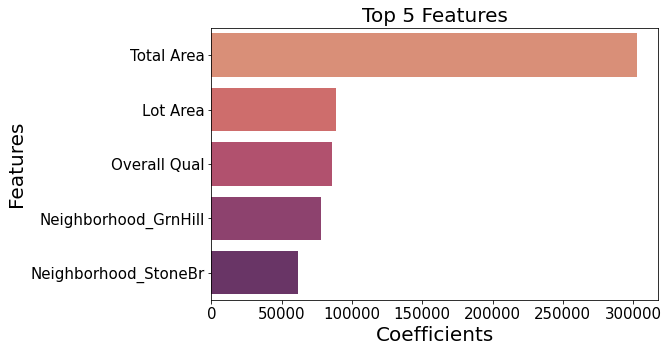

In [72]:
#Bar plots of top 5 most important features
plt.figure(figsize = (8, 5))

top_5 = lasso_coef_df.head()

sns.barplot(x= top_5['coef'],y= top_5['index'],palette = "flare")
plt.title('Top 5 Features',fontsize=20)
plt.xlabel('Coefficients',fontsize=20)
plt.ylabel('Features',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15);

## 5.2 Visualisation of Important Features
Important features are selected:
- Total area
- Overall quality
- Neighborhood

### Area

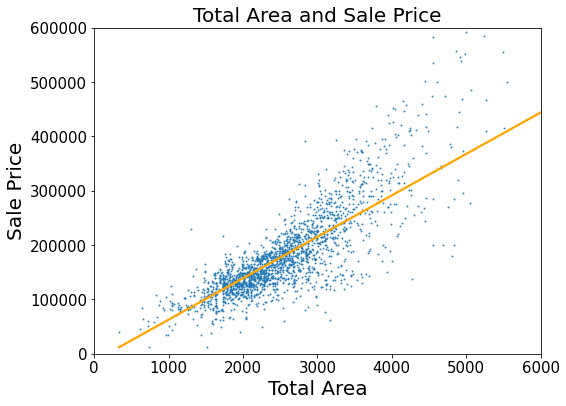

In [73]:
plt.figure(figsize = (8, 6))
sns.regplot(x='Total Area',y='SalePrice',data=Xy,scatter_kws={'s':1},line_kws={'color':'orange'},ci=None)
plt.xlim(0,6000)
plt.ylim(0,600000)
plt.title('Total Area and Sale Price',fontsize=20)
plt.xlabel('Total Area',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

- Total area has come out to be the strongest predictor.
- Indeed, based on the plot, houses with larger area also have higher sale price. 

### Overall Quality

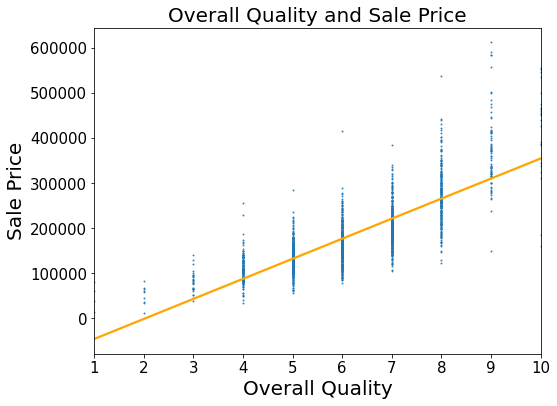

In [74]:
plt.figure(figsize = (8, 6))
sns.regplot(x='Overall Qual',y='SalePrice',data=Xy,scatter_kws={'s':1},line_kws={'color':'orange'}, ci=None)
plt.title('Overall Quality and Sale Price',fontsize=20)
plt.xlabel('Overall Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(1,10);

- Higher quality leads to higher sale price

### Neighborhood

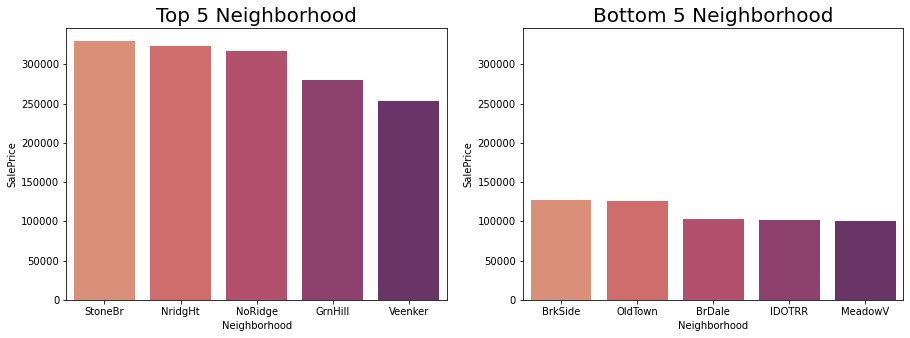

In [75]:
# Top 5 and Bottom 5 Neighbourhood in Sale Price
fig,ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))

avg_saleprice_by_neighborhood = Xy.groupby('Neighborhood')['SalePrice'].agg('mean').to_frame().reset_index().sort_values(by='SalePrice',ascending=False)
top_5 = avg_saleprice_by_neighborhood.head()
bottom_5 = avg_saleprice_by_neighborhood.tail()

sns.barplot(y= top_5['SalePrice'], x= top_5['Neighborhood'], palette = "flare", ax=ax[0])
ax[0].set_title('Top 5 Neighborhood',fontsize=20);

sns.barplot(y= bottom_5['SalePrice'], x= bottom_5['Neighborhood'], palette = "flare",ax=ax[1])
ax[1].set_title('Bottom 5 Neighborhood',fontsize=20);

plt.tick_params(left=True,labelleft=True)

- Huge difference in average sale price was observed among different neighborhood.
- Most expensive neighborhood is more than twice the price of cheapest neighborhood.

# 6 Conclusion

**Summary of Findings**

- Most important features for property sale price is living area, overall quality and location.
- Living area is the strongest predictor for sale price.
- Huge difference in sale price was observed among different neighborhood, with most expensive neighborhood more than twice the price of cheapest neighborhood. This highlights the importance of prime location for purchasing and selling property.
- Improving quality of the house by upgrading the finish and materials can bring price uplist for homeowners looking to sell their property.

**Future Steps**

- Sale price prediction model can be tested against other property market outside Ames, Iowa to understand model generalisability and to identify features that are robust in different markets.

# Appendix: Output for Kaggle Submission

In [76]:
#Transform kaggle_test
kaggle_test_transformed = preprocessor_pipeline_sig.transform (kaggle_test[significant_features])

/Users/yangyangxie/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning:

Found unknown categories in columns [8, 9, 10, 13, 14] during transform. These unknown categories will be encoded as all zeros



In [77]:
#Output y_pred for submission
output = pd.DataFrame()
output['SalePrice'] = lasso_gridsearch.predict(kaggle_test_transformed)
output['Id'] = kaggle_test['Id'].map(int)
output.to_csv('kaggle_submission/output.csv',index=False)